In [1]:
import pybaseball as pyb
from pybaseball import statcast, pitching_stats, playerid_lookup, statcast_pitcher, statcast_pitcher_pitch_arsenal, pitching_stats_bref, pitching_stats_range
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import re
import unicodedata
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

C:\Users\johns\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [30]:
pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e8/37/3afd3c02798734efcd7840bfa872d3efc06f5d5c92f9613fea3ff5b4311f/catboost-1.2.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 1.4 MB/s eta 0:01:14
   ---------------------------------------- 0.4/101.1 MB 5.8 MB/s eta 0:00:18
   ---------------------------------------- 0.9/101.1 MB 8.4 MB/s eta 0:00:12
    --------------------------------------- 1.5/101.1 MB 9.3 MB/s eta 0:00:11
    --------------------------------------- 2.0/101.1 MB 10.0 MB/s eta 0:00:10
   - -------------------------------------- 2.6/101.1 MB 10.4 MB/s eta 0:00:10
   - -------------------------------------- 3.2

In [2]:
complete_100_df = pd.read_csv('complete_100_df.csv', index_col=0)

In [24]:
complete_100_df

,Name,Age,pitcher,season,pitch_type,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery,TJ Surgery Year
0,adam wainwright,41.0,425794,2023,CH,91,81.504396,-1.330769,53.993407,6.145385,4.245696,-118.558747,-4.409017,1,1.0,2011.0
1,adam wainwright,41.0,425794,2023,CS,3,65.733333,-1.520000,54.506667,6.410000,-0.628298,-95.480064,4.033457,1,1.0,2011.0
2,adam wainwright,41.0,425794,2023,CU,545,71.502569,-1.242385,54.176661,6.286018,0.256395,-103.981304,0.991996,1,1.0,2011.0
3,adam wainwright,41.0,425794,2023,FC,403,82.861290,-1.215806,54.015236,6.287072,3.112750,-120.682959,-3.743577,1,1.0,2011.0
4,adam wainwright,41.0,425794,2023,FF,176,85.715341,-1.229432,53.974261,6.250625,2.547035,-124.786559,-4.628487,1,1.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21386,jeff samardzija,23.0,502188,2008,FS,99,86.302020,-2.333232,54.500000,6.583636,6.802709,-126.226226,-5.324773,1,0.0,NaN
21387,jeff samardzija,23.0,502188,2008,IN,6,68.650000,-2.868333,54.500000,6.941667,-1.886758,-100.577489,0.512961,1,0.0,NaN
21388,jeff samardzija,23.0,502188,2008,PO,1,84.900000,-3.120000,54.500000,6.670000,-2.171512,-124.318167,7.649149,1,0.0,NaN
21389,jeff samardzija,23.0,502188,2008,SI,83,95.686747,-2.495542,54.500000,6.357831,9.600795,-139.918356,-4.335994,1,0.0,NaN


In [26]:
complete_100_df['Surgery'].value_counts()

Surgery
0.0    16389
1.0     5002
Name: count, dtype: int64

In [23]:
wainwright_df = complete_100_df[complete_100_df['Name'] == 'adam wainwright']
wainwright_df

,Name,Age,pitcher,season,pitch_type,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery,TJ Surgery Year
0,adam wainwright,41.0,425794,2023,CH,91,81.504396,-1.330769,53.993407,6.145385,4.245696,-118.558747,-4.409017,1,1.0,2011.0
1,adam wainwright,41.0,425794,2023,CS,3,65.733333,-1.520000,54.506667,6.410000,-0.628298,-95.480064,4.033457,1,1.0,2011.0
2,adam wainwright,41.0,425794,2023,CU,545,71.502569,-1.242385,54.176661,6.286018,0.256395,-103.981304,0.991996,1,1.0,2011.0
3,adam wainwright,41.0,425794,2023,FC,403,82.861290,-1.215806,54.015236,6.287072,3.112750,-120.682959,-3.743577,1,1.0,2011.0
4,adam wainwright,41.0,425794,2023,FF,176,85.715341,-1.229432,53.974261,6.250625,2.547035,-124.786559,-4.628487,1,1.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20627,adam wainwright,26.0,425794,2008,FC,395,85.016456,-1.160532,54.500000,6.777924,3.208322,-124.593499,-4.273229,1,0.0,2011.0
20628,adam wainwright,26.0,425794,2008,FF,101,90.300990,-0.982178,54.500000,6.884158,3.708786,-132.242249,-7.209294,1,0.0,2011.0
20629,adam wainwright,26.0,425794,2008,IN,4,72.800000,-2.007500,54.500000,6.937500,-3.290710,-106.914426,-1.276241,1,0.0,2011.0
20630,adam wainwright,26.0,425794,2008,PO,2,79.800000,-1.285000,54.500000,6.790000,13.489560,-116.484483,1.422418,1,0.0,2011.0


In [13]:
# Correcting the approach to ensure 'Surgery' is 1.0 from the surgery year onwards, including the surgery year itself
complete_100_df['Surgery'] = complete_100_df.apply(lambda row: 1.0 if row['season'] >= row['TJ Surgery Year'] else 0.0, axis=1)

complete_100_df

,Name,Age,pitcher,season,pitch_type,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery,TJ Surgery Year
0,adam wainwright,41.0,425794,2023,CH,91,81.504396,-1.330769,53.993407,6.145385,4.245696,-118.558747,-4.409017,1,1.0,2011.0
1,adam wainwright,41.0,425794,2023,CS,3,65.733333,-1.520000,54.506667,6.410000,-0.628298,-95.480064,4.033457,1,1.0,2011.0
2,adam wainwright,41.0,425794,2023,CU,545,71.502569,-1.242385,54.176661,6.286018,0.256395,-103.981304,0.991996,1,1.0,2011.0
3,adam wainwright,41.0,425794,2023,FC,403,82.861290,-1.215806,54.015236,6.287072,3.112750,-120.682959,-3.743577,1,1.0,2011.0
4,adam wainwright,41.0,425794,2023,FF,176,85.715341,-1.229432,53.974261,6.250625,2.547035,-124.786559,-4.628487,1,1.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21386,jeff samardzija,23.0,502188,2008,FS,99,86.302020,-2.333232,54.500000,6.583636,6.802709,-126.226226,-5.324773,1,0.0,NaN
21387,jeff samardzija,23.0,502188,2008,IN,6,68.650000,-2.868333,54.500000,6.941667,-1.886758,-100.577489,0.512961,1,0.0,NaN
21388,jeff samardzija,23.0,502188,2008,PO,1,84.900000,-3.120000,54.500000,6.670000,-2.171512,-124.318167,7.649149,1,0.0,NaN
21389,jeff samardzija,23.0,502188,2008,SI,83,95.686747,-2.495542,54.500000,6.357831,9.600795,-139.918356,-4.335994,1,0.0,NaN


This ensures that we are only counting for 'Surgery' for the year of surgery, and all years going forward.

In [17]:
filtered_rows = complete_100_df[(complete_100_df['Surgery'] == 1.0) & (complete_100_df['TJ Surgery Year'].isna())]
filtered_rows

,Name,Age,pitcher,season,pitch_type,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery,TJ Surgery Year


In [19]:
pd.set_option('display.max_rows', None)

In [22]:
pd.reset_option('display.max_rows')

In [27]:
complete_100_df['TJ Surgery Year'].fillna(0.0, inplace=True)

C:\Users\johns\AppData\Local\Temp\ipykernel_8568\550959113.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_100_df['TJ Surgery Year'].fillna(0.0, inplace=True)


In [7]:
"""
# Fill NaN in 'TJ Surgery Year' with 0.0
complete_100_df['TJ Surgery Year'].fillna(0.0, inplace=True)

# Update 'Surgery' based on 'season' and 'TJ Surgery Year'
complete_100_df['Surgery'] = complete_100_df.apply(
    lambda row: 1.0 if row['season'] >= row['TJ Surgery Year'] and row['TJ Surgery Year'] != 0 else 0.0, axis=1
)

# Verify the changes
print(complete_100_df[['Name', 'season', 'TJ Surgery Year', 'Surgery']].head())

# Check the value counts again
print(complete_100_df['Surgery'].value_counts())
"""

C:\Users\johns\AppData\Local\Temp\ipykernel_32520\2928425957.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_100_df['TJ Surgery Year'].fillna(0.0, inplace=True)


              Name  season  TJ Surgery Year  Surgery
0  adam wainwright    2023           2011.0      1.0
1  adam wainwright    2023           2011.0      1.0
2  adam wainwright    2023           2011.0      1.0
3  adam wainwright    2023           2011.0      1.0
4  adam wainwright    2023           2011.0      1.0
Surgery
0.0    16389
1.0     5002
Name: count, dtype: int64


In [28]:
complete_100_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21391 entries, 0 to 21390
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Name                              21391 non-null  object 
 1   Age                               21391 non-null  float64
 2   pitcher                           21391 non-null  int64  
 3   season                            21391 non-null  int64  
 4   pitch_type                        21391 non-null  object 
 5   season_total_count_by_pitch_type  21391 non-null  int64  
 6   release_speed_weighted_avg        21391 non-null  float64
 7   release_pos_x_weighted_avg        21391 non-null  float64
 8   release_pos_y_weighted_avg        21391 non-null  float64
 9   release_pos_z_weighted_avg        21391 non-null  float64
 10  vx0_weighted_avg                  21391 non-null  float64
 11  vy0_weighted_avg                  21391 non-null  float64
 12  vz0_weigh

Can probably drop 'Name' and 'TJ Surgery Year' columns

In [66]:
funky_df = complete_100_df.drop(columns=['Name', 'TJ Surgery Year'])

In [67]:
funky_df

,Age,pitcher,season,pitch_type,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery
0,41.0,425794,2023,CH,91,81.504396,-1.330769,53.993407,6.145385,4.245696,-118.558747,-4.409017,1,1.0
1,41.0,425794,2023,CS,3,65.733333,-1.520000,54.506667,6.410000,-0.628298,-95.480064,4.033457,1,1.0
2,41.0,425794,2023,CU,545,71.502569,-1.242385,54.176661,6.286018,0.256395,-103.981304,0.991996,1,1.0
3,41.0,425794,2023,FC,403,82.861290,-1.215806,54.015236,6.287072,3.112750,-120.682959,-3.743577,1,1.0
4,41.0,425794,2023,FF,176,85.715341,-1.229432,53.974261,6.250625,2.547035,-124.786559,-4.628487,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21386,23.0,502188,2008,FS,99,86.302020,-2.333232,54.500000,6.583636,6.802709,-126.226226,-5.324773,1,0.0
21387,23.0,502188,2008,IN,6,68.650000,-2.868333,54.500000,6.941667,-1.886758,-100.577489,0.512961,1,0.0
21388,23.0,502188,2008,PO,1,84.900000,-3.120000,54.500000,6.670000,-2.171512,-124.318167,7.649149,1,0.0
21389,23.0,502188,2008,SI,83,95.686747,-2.495542,54.500000,6.357831,9.600795,-139.918356,-4.335994,1,0.0


In [68]:
funky_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21391 entries, 0 to 21390
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               21391 non-null  float64
 1   pitcher                           21391 non-null  int64  
 2   season                            21391 non-null  int64  
 3   pitch_type                        21391 non-null  object 
 4   season_total_count_by_pitch_type  21391 non-null  int64  
 5   release_speed_weighted_avg        21391 non-null  float64
 6   release_pos_x_weighted_avg        21391 non-null  float64
 7   release_pos_y_weighted_avg        21391 non-null  float64
 8   release_pos_z_weighted_avg        21391 non-null  float64
 9   vx0_weighted_avg                  21391 non-null  float64
 10  vy0_weighted_avg                  21391 non-null  float64
 11  vz0_weighted_avg                  21391 non-null  float64
 12  Throws   

In [69]:
funky_df['pitch_type'].value_counts()

pitch_type
FF    3641
CH    3356
SI    3286
SL    2775
CU    2670
FC    1625
IN    1605
PO    1045
KC     525
FS     390
ST     129
FA     124
EP      90
CS      52
SV      29
KN      25
AB      14
SC      10
Name: count, dtype: int64

In [70]:
funky_df['release_pos_y_weighted_avg'].value_counts()

release_pos_y_weighted_avg
54.500000    14019
54.580000        7
54.780000        6
54.360000        6
54.160000        6
             ...  
54.247143        1
54.289964        1
54.083586        1
54.099168        1
55.031195        1
Name: count, Length: 6936, dtype: int64

In [58]:
fa_rows = funky_df[funky_df['pitch_type'] == 'FA']

In [59]:
fa_rows

,Age,pitcher,season,pitch_type,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery
67,35.0,477132,2023,FA,1,64.700000,2.520000,57.490000,8.110000,-2.888858,-94.169277,0.717672,0,0.0
168,33.0,543101,2023,FA,1,77.500000,-1.810000,54.130000,5.580000,4.269917,-112.756231,-3.866737,1,0.0
196,32.0,543475,2023,FA,1,54.800000,-2.500000,54.410000,7.010000,2.738477,-79.868282,0.969259,1,0.0
1869,37.0,425844,2021,FA,9,80.777778,-1.248889,54.542222,6.225556,3.282386,-117.661816,-4.283156,1,0.0
2892,36.0,425844,2020,FA,57,78.835088,-1.174035,54.486842,6.237018,1.925600,-114.799739,-3.573492,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20964,23.0,444836,2008,FA,2,86.550000,2.985000,54.500000,5.295000,-11.060823,-126.333327,-0.147313,0,0.0
21019,27.0,446454,2008,FA,7,89.100000,-2.560000,54.500000,5.785714,7.097111,-130.534249,-4.385059,1,0.0
21211,25.0,456043,2008,FA,20,89.060000,2.436500,54.500000,5.844500,-9.264289,-130.337173,-3.683376,0,0.0
21219,22.0,456501,2008,FA,1,91.600000,-2.200000,54.500000,5.490000,6.857175,-134.412022,-0.483711,1,0.0


Try condensing pitch_type before the pivot and compare.

In [60]:
condensed_pitch_type_df = funky_df

In [61]:
pitch_type_mapping = {
    'FF': 'FB', 'SI': 'FB', 'FC': 'FB', 'FA': 'FB',
    'CH': 'OS', 'FS': 'OS', 'FO': 'OS', 'SC': 'OS', 'PO': 'OS',
    'CU': 'BB', 'KC': 'BB', 'CS': 'BB',
    'SL': 'SB', 'ST': 'SB', 'SV': 'SB', 'KN': 'SB',
    'EP': 'OT', 'AB': 'OT', 'IN': 'OT'
}

condensed_pitch_type_df['pitch_type_group'] = condensed_pitch_type_df['pitch_type'].map(pitch_type_mapping)

In [63]:
grouped_df = condensed_pitch_type_df.groupby(['Age', 'pitcher', 'season', 'pitch_type_group']).agg(
    season_total_count_by_pitch_type=('season_total_count_by_pitch_type', 'sum'),
    release_speed_weighted_avg=('release_speed_weighted_avg', 'mean'),
    release_pos_x_weighted_avg=('release_pos_x_weighted_avg', 'mean'),
    release_pos_y_weighted_avg=('release_pos_y_weighted_avg', 'mean'),
    release_pos_z_weighted_avg=('release_pos_z_weighted_avg', 'mean'),
    vx0_weighted_avg=('vx0_weighted_avg', 'mean'),
    vy0_weighted_avg=('vy0_weighted_avg', 'mean'),
    vz0_weighted_avg=('vz0_weighted_avg', 'mean'),
    Throws=('Throws', 'first'),  # Assuming Throws doesn't change within groups
    Surgery=('Surgery', 'first')  # Assuming Surgery doesn't change within groups
).reset_index()


In [64]:
grouped_df

,Age,pitcher,season,pitch_type_group,season_total_count_by_pitch_type,release_speed_weighted_avg,release_pos_x_weighted_avg,release_pos_y_weighted_avg,release_pos_z_weighted_avg,vx0_weighted_avg,vy0_weighted_avg,vz0_weighted_avg,Throws,Surgery
0,19.0,518516,2009,BB,42,78.269048,3.856905,54.5,5.708571,-6.721445,-114.582868,0.671529,0,0.0
1,19.0,518516,2009,FB,98,90.704035,3.717070,54.5,5.590175,-11.789907,-132.592917,-4.175544,0,0.0
2,19.0,518516,2009,OS,12,83.358333,3.658333,54.5,5.648333,-9.747959,-121.830761,-2.242362,0,0.0
3,19.0,518516,2009,OT,4,78.175000,3.642500,54.5,5.947500,-3.005478,-114.849569,1.932487,0,0.0
4,19.0,605164,2012,BB,1,75.000000,-1.690000,54.5,6.200000,4.511180,-109.939402,0.323191,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14707,47.0,119469,2010,OS,306,74.809477,3.145327,54.5,6.149085,-7.895896,-109.519169,-2.217449,0,1.0
14708,49.0,119469,2012,BB,90,69.217778,2.931333,54.5,6.383000,-5.499251,-101.342735,2.099376,0,1.0
14709,49.0,119469,2012,FB,628,78.273372,3.087675,54.5,6.156644,-8.337149,-114.411243,-1.943725,0,1.0
14710,49.0,119469,2012,OS,301,72.568771,3.122791,54.5,6.133455,-8.131883,-106.090452,-1.344874,0,1.0


In [65]:
grouped_df['release_pos_y_weighted_avg'].value_counts()

release_pos_y_weighted_avg
54.500000    9540
54.160000       3
53.970000       3
53.980000       3
54.110000       3
             ... 
54.281383       1
54.396867       1
53.962602       1
54.059634       1
55.724512       1
Name: count, Length: 5138, dtype: int64

In [72]:
def pivot_metrics(df, index_cols, pivot_col, value_cols):
    """
    Pivot the DataFrame for the specified pivot column.
    :param df: DataFrame to pivot.
    :param index_cols: List of columns to use as the index.
    :param pivot_col: Column to pivot on.
    :param value_cols: Columns whose values are to be spread across pivoted columns.
    :return: Pivoted DataFrame.
    """
    pivoted_dfs = []
    for value_col in value_cols:
        # Pivot each metric column separately and rename to include the pitch_type
        pivoted_df = df.pivot_table(index=index_cols, columns=pivot_col, values=value_col, aggfunc='first').reset_index()
        pivoted_df.columns = [f"{col}_{value_col}" if col not in index_cols else col for col in pivoted_df.columns]
        pivoted_dfs.append(pivoted_df)
    
    # Merge all the pivoted metric DataFrames on the index columns
    from functools import reduce
    final_df = reduce(lambda left, right: pd.merge(left, right, on=index_cols, how='outer'), pivoted_dfs)
    return final_df

# Define the base columns and the metrics you want to pivot
index_cols = ['pitcher', 'season', 'Age', 'Throws', 'Surgery']
pivot_col = 'pitch_type_group'
value_cols = ['release_speed_weighted_avg', 'release_pos_x_weighted_avg', 'release_pos_y_weighted_avg', 'release_pos_z_weighted_avg', 'vx0_weighted_avg', 'vy0_weighted_avg', 'vz0_weighted_avg']

# Pivot the DataFrame
cond_pivoted_df = pivot_metrics(grouped_df, index_cols, pivot_col, value_cols)

cond_pivoted_df.head()

,pitcher,season,Age,Throws,Surgery,BB_release_speed_weighted_avg,FB_release_speed_weighted_avg,OS_release_speed_weighted_avg,OT_release_speed_weighted_avg,SB_release_speed_weighted_avg,...,BB_vy0_weighted_avg,FB_vy0_weighted_avg,OS_vy0_weighted_avg,OT_vy0_weighted_avg,SB_vy0_weighted_avg,BB_vz0_weighted_avg,FB_vz0_weighted_avg,OS_vz0_weighted_avg,OT_vz0_weighted_avg,SB_vz0_weighted_avg
0,110683,2008,37.0,1,0.0,75.425843,91.689850,81.458265,50.600000,86.827813,...,-110.627789,-134.352990,-119.317618,-73.714833,-127.257269,-1.246458,-4.126779,-0.780223,7.335296,-3.339929
1,110683,2009,38.0,1,0.0,78.181818,93.479869,85.012195,53.500000,87.919825,...,-114.570196,-136.926151,-124.551149,-78.119736,-128.804060,-0.254067,-3.423404,-1.272244,4.971030,-2.492202
2,110683,2010,39.0,1,0.0,74.666667,93.001617,84.025000,58.238462,87.052860,...,-109.676484,-136.276075,-122.891563,-84.907173,-127.505575,1.382751,-3.954090,-1.065173,5.705495,-3.186056
3,110683,2011,40.0,1,0.0,76.885714,91.678506,83.846875,52.594444,86.538075,...,-112.607261,-134.395791,-122.486963,-76.761205,-126.775541,-2.271918,-3.157704,-1.472148,7.108895,-2.303028
4,110683,2012,41.0,1,0.0,76.427273,91.965592,83.001563,50.375000,85.657742,...,-112.083840,-134.748594,-121.548068,-73.528548,-125.463237,-0.468344,-4.148174,-3.095360,7.101314,-2.684632


In [73]:
cond_pivoted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3688 entries, 0 to 3687
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   pitcher                        3688 non-null   int64  
 1   season                         3688 non-null   int64  
 2   Age                            3688 non-null   float64
 3   Throws                         3688 non-null   int64  
 4   Surgery                        3688 non-null   float64
 5   BB_release_speed_weighted_avg  3059 non-null   float64
 6   FB_release_speed_weighted_avg  3688 non-null   float64
 7   OS_release_speed_weighted_avg  3562 non-null   float64
 8   OT_release_speed_weighted_avg  1610 non-null   float64
 9   SB_release_speed_weighted_avg  2793 non-null   float64
 10  BB_release_pos_x_weighted_avg  3059 non-null   float64
 11  FB_release_pos_x_weighted_avg  3688 non-null   float64
 12  OS_release_pos_x_weighted_avg  3562 non-null   f

This condensed DF has 40 columns compared to before where I had 130 columns.

In [74]:
cond_pivoted_df.fillna(0.0, inplace=True)

In [75]:
cond_pivoted_df.to_csv('cond_pivoted_df.csv')

In [76]:
cond_groovy_df = cond_pivoted_df

In [77]:
cond_groovy_df.drop(columns=['pitcher'], inplace=True)

In [78]:
y = cond_groovy_df['Surgery']
X = cond_groovy_df.drop('Surgery', axis=1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Define the parameter grid to search over
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2']  # Norm used in the penalization
}

# Initialize GridSearchCV with the pipeline, parameter grid, and desired scoring metric
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='accuracy')

# Assuming X_train and y_train are already defined
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters: ", grid_search.best_params_)

# Best cross-validation score
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Test set score using the best parameters
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

C:\Users\johns\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johns\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johns\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johns\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johns\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters:  {'logreg__C': 1, 'logreg__penalty': 'l1'}
Best cross-validation score: 0.75
Test set score: 0.75


In [81]:
logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', C=1.0, solver='liblinear'))
])

In [82]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logreg',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [83]:
logreg_pipeline.score(X_test, y_test)

0.7497741644083108

In [84]:
y_pred = logreg_pipeline.predict(X_test)

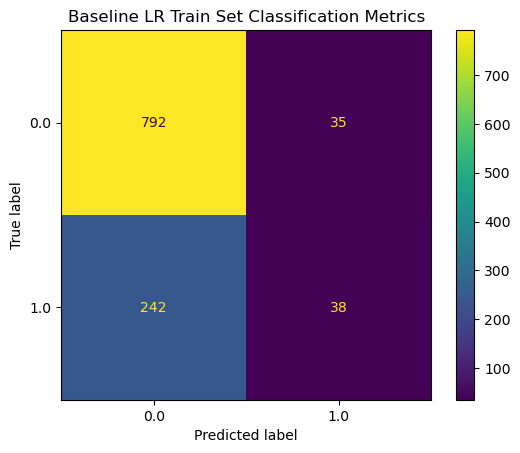

              precision    recall  f1-score   support

         0.0       0.77      0.96      0.85       827
         1.0       0.52      0.14      0.22       280

    accuracy                           0.75      1107
   macro avg       0.64      0.55      0.53      1107
weighted avg       0.70      0.75      0.69      1107



In [85]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Baseline LR Train Set Classification Metrics')
plt.show()
print(classification_report(y_test, y_pred))

recall score was even worse for this. Will try with SMOTE on google colab

In [31]:
def pivot_metrics(df, index_cols, pivot_col, value_cols):
    """
    Pivot the DataFrame for the specified pivot column.
    :param df: DataFrame to pivot.
    :param index_cols: List of columns to use as the index.
    :param pivot_col: Column to pivot on.
    :param value_cols: Columns whose values are to be spread across pivoted columns.
    :return: Pivoted DataFrame.
    """
    pivoted_dfs = []
    for value_col in value_cols:
        # Pivot each metric column separately and rename to include the pitch_type
        pivoted_df = df.pivot_table(index=index_cols, columns=pivot_col, values=value_col, aggfunc='first').reset_index()
        pivoted_df.columns = [f"{col}_{value_col}" if col not in index_cols else col for col in pivoted_df.columns]
        pivoted_dfs.append(pivoted_df)
    
    # Merge all the pivoted metric DataFrames on the index columns
    from functools import reduce
    final_df = reduce(lambda left, right: pd.merge(left, right, on=index_cols, how='outer'), pivoted_dfs)
    return final_df

# Define the base columns and the metrics you want to pivot
index_cols = ['pitcher', 'season', 'Age', 'Throws', 'Surgery']
pivot_col = 'pitch_type'
value_cols = ['release_speed_weighted_avg', 'release_pos_x_weighted_avg', 'release_pos_y_weighted_avg', 'release_pos_z_weighted_avg', 'vx0_weighted_avg', 'vy0_weighted_avg', 'vz0_weighted_avg']

# Pivot the DataFrame
pivoted_df = pivot_metrics(funky_df, index_cols, pivot_col, value_cols)

pivoted_df.head()

,pitcher,season,Age,Throws,Surgery,AB_release_speed_weighted_avg,CH_release_speed_weighted_avg,CS_release_speed_weighted_avg,CU_release_speed_weighted_avg,EP_release_speed_weighted_avg,...,FS_vz0_weighted_avg,IN_vz0_weighted_avg,KC_vz0_weighted_avg,KN_vz0_weighted_avg,PO_vz0_weighted_avg,SC_vz0_weighted_avg,SI_vz0_weighted_avg,SL_vz0_weighted_avg,ST_vz0_weighted_avg,SV_vz0_weighted_avg
0,110683,2008,37.0,1,0.0,NaN,82.641530,NaN,75.425843,NaN,...,NaN,7.335296,NaN,NaN,1.676319,NaN,-4.087597,-3.339929,NaN,NaN
1,110683,2009,38.0,1,0.0,NaN,85.012195,NaN,78.181818,NaN,...,NaN,4.971030,NaN,NaN,NaN,NaN,-3.124205,-2.492202,NaN,NaN
2,110683,2010,39.0,1,0.0,NaN,84.150000,NaN,74.666667,NaN,...,NaN,5.705495,NaN,NaN,-0.118320,NaN,-3.576961,-3.186056,NaN,NaN
3,110683,2011,40.0,1,0.0,NaN,83.093750,NaN,76.885714,NaN,...,NaN,7.108895,NaN,NaN,-0.907724,NaN,-3.631151,-2.303028,NaN,NaN
4,110683,2012,41.0,1,0.0,NaN,83.001563,NaN,76.427273,NaN,...,NaN,7.101314,NaN,NaN,NaN,NaN,-4.538380,-2.684632,NaN,NaN


In [36]:
pivoted_df

,pitcher,season,Age,Throws,Surgery,AB_release_speed_weighted_avg,CH_release_speed_weighted_avg,CS_release_speed_weighted_avg,CU_release_speed_weighted_avg,EP_release_speed_weighted_avg,...,FS_vz0_weighted_avg,IN_vz0_weighted_avg,KC_vz0_weighted_avg,KN_vz0_weighted_avg,PO_vz0_weighted_avg,SC_vz0_weighted_avg,SI_vz0_weighted_avg,SL_vz0_weighted_avg,ST_vz0_weighted_avg,SV_vz0_weighted_avg
0,110683,2008,37.0,1,0.0,0.0,82.641530,0.0,75.425843,0.0,...,0.000000,7.335296,0.000000,0.0,1.676319,0.0,-4.087597,-3.339929,0.000000,0.0
1,110683,2009,38.0,1,0.0,0.0,85.012195,0.0,78.181818,0.0,...,0.000000,4.971030,0.000000,0.0,0.000000,0.0,-3.124205,-2.492202,0.000000,0.0
2,110683,2010,39.0,1,0.0,0.0,84.150000,0.0,74.666667,0.0,...,0.000000,5.705495,0.000000,0.0,-0.118320,0.0,-3.576961,-3.186056,0.000000,0.0
3,110683,2011,40.0,1,0.0,0.0,83.093750,0.0,76.885714,0.0,...,0.000000,7.108895,0.000000,0.0,-0.907724,0.0,-3.631151,-2.303028,0.000000,0.0
4,110683,2012,41.0,1,0.0,0.0,83.001563,0.0,76.427273,0.0,...,0.000000,7.101314,0.000000,0.0,0.000000,0.0,-4.538380,-2.684632,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3683,672578,2022,25.0,1,0.0,0.0,0.000000,0.0,0.000000,0.0,...,-4.908882,0.000000,-2.356367,0.0,0.000000,0.0,-5.774490,-3.849656,0.000000,0.0
3684,672578,2023,26.0,1,0.0,0.0,0.000000,0.0,0.000000,0.0,...,-5.941950,0.000000,-2.245103,0.0,0.000000,0.0,-8.909924,-4.652536,0.000000,0.0
3685,680686,2021,23.0,1,0.0,0.0,89.195000,0.0,83.752117,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,-3.078047,0.000000,0.0
3686,680686,2022,24.0,1,0.0,0.0,88.143056,0.0,82.712868,0.0,...,0.000000,0.000000,0.000000,0.0,3.830690,0.0,-4.884627,-2.835997,0.000000,0.0


In [35]:
pivoted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3688 entries, 0 to 3687
Columns: 131 entries, pitcher to SV_vz0_weighted_avg
dtypes: float64(128), int64(3)
memory usage: 3.7 MB


In [34]:
pivoted_df.fillna(0.0, inplace=True)

In [54]:
pivoted_df.to_csv('pivoted_df.csv')

In [37]:
pivoted_df.columns

Index(['pitcher', 'season', 'Age', 'Throws', 'Surgery',
       'AB_release_speed_weighted_avg', 'CH_release_speed_weighted_avg',
       'CS_release_speed_weighted_avg', 'CU_release_speed_weighted_avg',
       'EP_release_speed_weighted_avg',
       ...
       'FS_vz0_weighted_avg', 'IN_vz0_weighted_avg', 'KC_vz0_weighted_avg',
       'KN_vz0_weighted_avg', 'PO_vz0_weighted_avg', 'SC_vz0_weighted_avg',
       'SI_vz0_weighted_avg', 'SL_vz0_weighted_avg', 'ST_vz0_weighted_avg',
       'SV_vz0_weighted_avg'],
      dtype='object', length=131)

In [82]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [91]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [38]:
groovy_df = pivoted_df

Drop 'pitcher' column for groovy_df. Only used as ID, should not be necessary.

In [40]:
groovy_df.drop(columns=['pitcher'], inplace=True)

In [41]:
groovy_df

,season,Age,Throws,Surgery,AB_release_speed_weighted_avg,CH_release_speed_weighted_avg,CS_release_speed_weighted_avg,CU_release_speed_weighted_avg,EP_release_speed_weighted_avg,FA_release_speed_weighted_avg,...,FS_vz0_weighted_avg,IN_vz0_weighted_avg,KC_vz0_weighted_avg,KN_vz0_weighted_avg,PO_vz0_weighted_avg,SC_vz0_weighted_avg,SI_vz0_weighted_avg,SL_vz0_weighted_avg,ST_vz0_weighted_avg,SV_vz0_weighted_avg
0,2008,37.0,1,0.0,0.0,82.641530,0.0,75.425843,0.0,0.0,...,0.000000,7.335296,0.000000,0.0,1.676319,0.0,-4.087597,-3.339929,0.000000,0.0
1,2009,38.0,1,0.0,0.0,85.012195,0.0,78.181818,0.0,0.0,...,0.000000,4.971030,0.000000,0.0,0.000000,0.0,-3.124205,-2.492202,0.000000,0.0
2,2010,39.0,1,0.0,0.0,84.150000,0.0,74.666667,0.0,0.0,...,0.000000,5.705495,0.000000,0.0,-0.118320,0.0,-3.576961,-3.186056,0.000000,0.0
3,2011,40.0,1,0.0,0.0,83.093750,0.0,76.885714,0.0,0.0,...,0.000000,7.108895,0.000000,0.0,-0.907724,0.0,-3.631151,-2.303028,0.000000,0.0
4,2012,41.0,1,0.0,0.0,83.001563,0.0,76.427273,0.0,0.0,...,0.000000,7.101314,0.000000,0.0,0.000000,0.0,-4.538380,-2.684632,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3683,2022,25.0,1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,-4.908882,0.000000,-2.356367,0.0,0.000000,0.0,-5.774490,-3.849656,0.000000,0.0
3684,2023,26.0,1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,-5.941950,0.000000,-2.245103,0.0,0.000000,0.0,-8.909924,-4.652536,0.000000,0.0
3685,2021,23.0,1,0.0,0.0,89.195000,0.0,83.752117,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,-3.078047,0.000000,0.0
3686,2022,24.0,1,0.0,0.0,88.143056,0.0,82.712868,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,3.830690,0.0,-4.884627,-2.835997,0.000000,0.0


In [42]:
groovy_df['Surgery'].value_counts()

Surgery
0.0    2772
1.0     916
Name: count, dtype: int64

In [43]:
groovy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3688 entries, 0 to 3687
Columns: 130 entries, season to SV_vz0_weighted_avg
dtypes: float64(128), int64(2)
memory usage: 3.7 MB


In [94]:
#sns.pairplot(groovy_df, hue='Surgery')

In [14]:
#ohe = OneHotEncoder(sparse_output=False)

In [101]:
"""
# Reshape your data as a 2D array of 'pitch_type' column values
pitch_type_array = groovy_df['pitch_type'].values.reshape(-1, 1)

# Fit and transform the 'pitch_type' column to one-hot encoded format
pitch_type_ohe = ohe.fit_transform(pitch_type_array)

# Convert the one-hot encoded result back to a DataFrame
pitch_type_df = pd.DataFrame(pitch_type_ohe, columns=ohe.get_feature_names_out(['pitch_type']))

# Concatenate the new one-hot encoded DataFrame with the original DataFrame (excluding the original 'pitch_type' column)
fancy_df = pd.concat([fancy_df.drop('pitch_type', axis=1).reset_index(drop=True), pitch_type_df], axis=1)

fancy_df.head()
"""

"\n# Reshape your data as a 2D array of 'pitch_type' column values\npitch_type_array = groovy_df['pitch_type'].values.reshape(-1, 1)\n\n# Fit and transform the 'pitch_type' column to one-hot encoded format\npitch_type_ohe = ohe.fit_transform(pitch_type_array)\n\n# Convert the one-hot encoded result back to a DataFrame\npitch_type_df = pd.DataFrame(pitch_type_ohe, columns=ohe.get_feature_names_out(['pitch_type']))\n\n# Concatenate the new one-hot encoded DataFrame with the original DataFrame (excluding the original 'pitch_type' column)\nfancy_df = pd.concat([fancy_df.drop('pitch_type', axis=1).reset_index(drop=True), pitch_type_df], axis=1)\n\nfancy_df.head()\n"

In [44]:
y = groovy_df['Surgery']
X = groovy_df.drop('Surgery', axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=10000))
])

# Define the parameter grid to search over
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2']  # Norm used in the penalization
}

# Initialize GridSearchCV with the pipeline, parameter grid, and desired scoring metric
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='accuracy')

# Assuming X_train and y_train are already defined
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters: ", grid_search.best_params_)

# Best cross-validation score
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Test set score using the best parameters
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters:  {'logreg__C': 10, 'logreg__penalty': 'l1'}
Best cross-validation score: 0.76
Test set score: 0.77


In [48]:
logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', C=10.0, solver='liblinear'))
])

In [49]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=10.0, penalty='l1', solver='liblinear'))])

In [50]:
logreg_pipeline.score(X_test, y_test)

0.7687443541102078

In [51]:
y_pred = logreg_pipeline.predict(X_test)

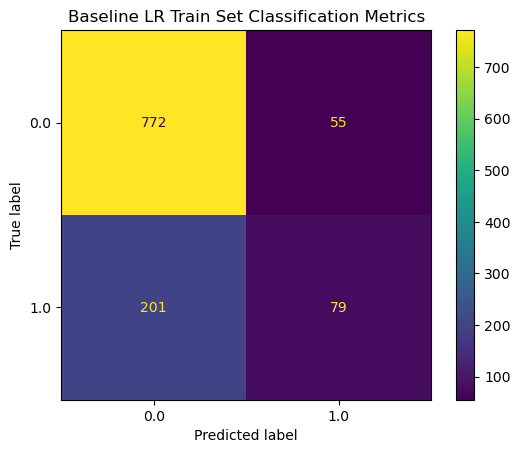

              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       827
         1.0       0.59      0.28      0.38       280

    accuracy                           0.77      1107
   macro avg       0.69      0.61      0.62      1107
weighted avg       0.74      0.77      0.74      1107



In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Baseline LR Train Set Classification Metrics')
plt.show()
print(classification_report(y_test, y_pred))

Want more false positives (think needs TJ but doesn't need TJ) than false negatives... 

Condense features (from 15 pitch types to 4)??

SMOTE? SMOTE Alternatives?

FIX SMOTE ISSUE

In [2]:
pip install --user scikit-learn imbalanced-learn